# Set Environment

In [115]:
# Import libraries
from datetime import timedelta
import os

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas_gbq

from IPython.display import display, HTML, Image
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20})

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

In [116]:
# authenticate
auth.authenticate_user()

In [117]:
# Set up environment variables
project_id = 'darshan-ml-health'
# if project_id == 'CHANGE-ME':
#   raise ValueError('You must change project_id to your GCP project.')
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id

# Read data from BigQuery into pandas dataframes.
def run_query(query, project_id=project_id):
  return pandas_gbq.read_gbq(
      query,
      project_id=project_id,
      dialect='standard')

# set the dataset
# if you want to use the demo, change this to mimic_demo
dataset = 'mimiciv'

# Feature Selection

## Select stroke patients

In [118]:
select_stroke_query = f"""
SELECT *
FROM `physionet-data.mimiciv_hosp.diagnoses_icd`
WHERE icd_code LIKE 'I61%' OR icd_code LIKE 'I63%';
"""
stroke_df = run_query(select_stroke_query)
stroke_subject_ids = stroke_df['subject_id'].unique().tolist()
stroke_hadm_ids = stroke_df['hadm_id'].unique().tolist()

Downloading: 100%|██████████|


## Demographics

### admittime, dischtime, deathtime, insurance, martial status, race

In [119]:
select_demographics_query_in_admission = f"""
SELECT subject_id, hadm_id, admittime, dischtime, deathtime, insurance, marital_status, race
FROM `physionet-data.mimiciv_hosp.admissions`
WHERE subject_id IN ({', '.join(map(str, stroke_subject_ids))})
AND hadm_id IN ({', '.join(map(str, stroke_hadm_ids))});
"""
demographics_df = run_query(select_demographics_query_in_admission)
demographics_df

Downloading: 100%|██████████|


,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND
...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE


### gender, age

In [120]:

select_gender_and_age_query = f"""
SELECT subject_id,gender, anchor_age
FROM `physionet-data.mimiciv_hosp.patients`
WHERE subject_id IN ({', '.join(map(str, stroke_subject_ids))});
"""
gender_and_df = run_query(select_gender_and_age_query)
demographics_df = demographics_df.merge(gender_and_df, on=['subject_id'], how='inner')
demographics_df

Downloading: 100%|██████████|


,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52
...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62


### weight

In [121]:
# 226512 Admission weight
select_weight_query = f"""SELECT subject_id, hadm_id, AVG(valuenum) as weight
FROM `physionet-data.mimiciv_icu.chartevents`
WHERE itemid = 226512 AND hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
GROUP BY subject_id, hadm_id;
"""
weight_df = run_query(select_weight_query)
weight_df

Downloading: 100%|██████████|


,subject_id,hadm_id,weight
0,17032851,26219826,86.0
1,16617024,27449764,63.0
2,10706021,26381791,72.7
3,19604256,24330860,68.4
4,16776268,28352347,60.3
...,...,...,...
2412,11997599,25252737,95.0
2413,16527226,21501769,98.9
2414,14889173,22451208,82.7
2415,19378928,23673648,44.8


In [122]:
demographics_df = demographics_df.merge(weight_df, on=['subject_id','hadm_id'], how='left')
demographics_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,weight
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,81.0
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,NaN
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,92.0


## Vital signs

In [123]:
# 220045  heart rate
# 220210  Respiratory Rate
# 220050  Arterial Blood Pressure systolic
# 220051  Arterial Blood Pressure diastolic
# 220052  Arterial Blood Pressure mean
# 228232  PAR-Oxygen saturation

select_vital_signs_query = f"""
SELECT *
FROM `physionet-data.mimiciv_icu.d_items`
WHERE itemid IN (220045, 220210, 220050, 220051, 220052, 228232);
"""
vital_signs_query = run_query(select_vital_signs_query)
vital_signs_query


Downloading: 100%|██████████|


,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,220210,Respiratory Rate,RR,chartevents,Respiratory,insp/min,Numeric,NaN,NaN
1,228232,PAR-Oxygen saturation,PAR-Oxygen saturation,chartevents,Routine Vital Signs,None,Text,NaN,NaN
2,220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,NaN,NaN
3,220050,Arterial Blood Pressure systolic,ABPs,chartevents,Routine Vital Signs,mmHg,Numeric,90.0,140.0
4,220051,Arterial Blood Pressure diastolic,ABPd,chartevents,Routine Vital Signs,mmHg,Numeric,60.0,90.0
5,220052,Arterial Blood Pressure mean,ABPm,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN


### Heart Rate

In [124]:
select_hr_query = f"""SELECT subject_id, hadm_id, AVG(valuenum) as hr_value
FROM `physionet-data.mimiciv_icu.chartevents`
WHERE itemid = 220045 AND subject_id IN ({', '.join(map(str, stroke_subject_ids))}) AND hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
GROUP BY subject_id, hadm_id;
"""
hr_df = run_query(select_hr_query)
hr_df

Downloading: 100%|██████████|


,subject_id,hadm_id,hr_value
0,17480292,25742975,96.116883
1,18157237,28285611,90.125000
2,16583373,27088456,61.580163
3,16653148,25267044,64.879630
4,18208117,24530240,72.911854
...,...,...,...
2415,14477428,22215973,74.750000
2416,15630763,20952730,109.411765
2417,13407727,27120094,61.304348
2418,10323105,26404816,69.638889


In [125]:
demographics_vitial_signs_df = demographics_df.merge(hr_df, on=['subject_id','hadm_id'], how='left')
demographics_vitial_signs_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,weight,hr_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,70.318519
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,81.0,118.038168
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,79.054054
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,NaN,NaN
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,84.944444
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN,NaN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN,NaN
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,92.0,63.617347


### Respiratory Rate

In [126]:
select_rr_query = f"""SELECT subject_id, hadm_id, AVG(valuenum) as rr_value
FROM `physionet-data.mimiciv_icu.chartevents`
WHERE itemid = 220210 AND subject_id IN ({', '.join(map(str, stroke_subject_ids))}) AND hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
GROUP BY subject_id, hadm_id;
"""
rr_df = run_query(select_rr_query)
rr_df

Downloading: 100%|██████████|


,subject_id,hadm_id,rr_value
0,19109471,25014327,18.125000
1,12109586,20636041,16.409091
2,16259359,28822852,23.427933
3,15972728,25902102,18.699507
4,17173309,22443690,22.849541
...,...,...,...
2414,19916287,29291295,15.200000
2415,16121000,27371517,22.684211
2416,17886662,21785093,18.000000
2417,12913705,29148179,16.166667


In [127]:
demographics_vitial_signs_df = demographics_vitial_signs_df.merge(rr_df, on=['subject_id','hadm_id'], how='left')
demographics_vitial_signs_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,weight,hr_value,rr_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,70.318519,15.644928
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,81.0,118.038168,23.454545
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,79.054054,13.436620
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,NaN,NaN,NaN
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,84.944444,19.305556
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN,NaN,NaN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN,NaN,NaN
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,92.0,63.617347,17.147959


### SPO2

In [128]:
select_SPO2_query = f"""SELECT subject_id, hadm_id, AVG(valuenum) as SPO2_value
FROM `physionet-data.mimiciv_icu.chartevents`
WHERE itemid = 228232 AND subject_id IN ({', '.join(map(str, stroke_subject_ids))}) AND hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
GROUP BY subject_id, hadm_id;
"""
SPO2_df = run_query(select_SPO2_query)
SPO2_df

Downloading: 100%|██████████|


,subject_id,hadm_id,SPO2_value
0,15456129,23276396,2.000000
1,17032851,26219826,1.444444
2,18532889,26946329,1.166667
3,13762552,27329464,1.000000
4,14643554,28137438,0.000000
...,...,...,...
177,11433416,29130896,1.500000
178,16080701,22251317,0.000000
179,11267564,21062142,1.000000
180,19136033,27656130,1.000000


In [129]:
demographics_vitial_signs_df = demographics_vitial_signs_df.merge(SPO2_df, on=['subject_id','hadm_id'], how='left')
demographics_vitial_signs_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,weight,hr_value,rr_value,SPO2_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,70.318519,15.644928,NaN
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,81.0,118.038168,23.454545,NaN
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,79.054054,13.436620,NaN
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,NaN,NaN,NaN,NaN
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,84.944444,19.305556,NaN
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN,NaN,NaN,NaN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN,NaN,NaN,NaN
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,92.0,63.617347,17.147959,NaN


### Arterial Blood Pressure systolic

In [130]:
select_BPS_query = f"""SELECT subject_id, hadm_id, AVG(valuenum) as BPS_value
FROM `physionet-data.mimiciv_icu.chartevents`
WHERE itemid = 220050 AND subject_id IN ({', '.join(map(str, stroke_subject_ids))}) AND hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
GROUP BY subject_id, hadm_id;
"""
BPS_df = run_query(select_BPS_query)
BPS_df

Downloading: 100%|██████████|


,subject_id,hadm_id,BPS_value
0,18204749,25728215,136.402439
1,19029474,26391327,119.762821
2,10400376,20763166,114.366972
3,11608370,29091108,162.429293
4,19678538,28383469,118.081340
...,...,...,...
751,18461335,28002627,126.090909
752,13817882,26548848,121.066667
753,14417339,28899895,128.600000
754,18179092,22786251,139.642857


In [131]:
demographics_vitial_signs_df = demographics_vitial_signs_df.merge(BPS_df, on=['subject_id','hadm_id'], how='left')
demographics_vitial_signs_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,weight,hr_value,rr_value,SPO2_value,BPS_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,70.318519,15.644928,NaN,NaN
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,81.0,118.038168,23.454545,NaN,128.6
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,79.054054,13.436620,NaN,NaN
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,NaN,NaN,NaN,NaN,NaN
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,84.944444,19.305556,NaN,NaN
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN,NaN,NaN,NaN,NaN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN,NaN,NaN,NaN,NaN
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,92.0,63.617347,17.147959,NaN,NaN


### Arterial Blood Pressure diastolic

In [132]:
select_BPD_query = f"""SELECT subject_id, hadm_id, AVG(valuenum) as BPD_value
FROM `physionet-data.mimiciv_icu.chartevents`
WHERE itemid = 220051 AND subject_id IN ({', '.join(map(str, stroke_subject_ids))}) AND hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
GROUP BY subject_id, hadm_id;
"""
BPD_df = run_query(select_BPD_query)
BPD_df



Downloading: 100%|██████████|


,subject_id,hadm_id,BPD_value
0,18119847,23243341,56.025641
1,13990571,27156036,54.010204
2,17584533,23218321,59.254762
3,18445490,21626778,65.047619
4,10347675,26643356,75.644764
...,...,...,...
751,18813819,27301107,55.000000
752,11079993,22360796,57.500000
753,11731531,24078707,68.090909
754,11953908,21366986,41.600000


In [133]:
demographics_vitial_signs_df = demographics_vitial_signs_df.merge(BPD_df, on=['subject_id','hadm_id'], how='left')
demographics_vitial_signs_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,weight,hr_value,rr_value,SPO2_value,BPS_value,BPD_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,70.318519,15.644928,NaN,NaN,NaN
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,81.0,118.038168,23.454545,NaN,128.6,59.6
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,79.054054,13.436620,NaN,NaN,NaN
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,NaN,NaN,NaN,NaN,NaN,NaN
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,84.944444,19.305556,NaN,NaN,NaN
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN,NaN,NaN,NaN,NaN,NaN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN,NaN,NaN,NaN,NaN,NaN
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,92.0,63.617347,17.147959,NaN,NaN,NaN


### Arterial Blood Pressure Mean

In [134]:
select_BPM_query = f"""SELECT subject_id, hadm_id, AVG(valuenum) as BPM_value
FROM `physionet-data.mimiciv_icu.chartevents`
WHERE itemid = 220052 AND subject_id IN ({', '.join(map(str, stroke_subject_ids))}) AND hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
GROUP BY subject_id, hadm_id;
"""
BPM_df = run_query(select_BPM_query)
BPM_df

Downloading: 100%|██████████|


,subject_id,hadm_id,BPM_value
0,16034243,26495696,91.117647
1,16841093,21934758,75.217391
2,19154640,20196064,87.093842
3,14331151,24487999,70.340879
4,14231889,27841923,70.956186
...,...,...,...
754,19573124,29652097,85.666667
755,18763543,20869455,64.785714
756,10205191,29698354,103.777778
757,18721180,24226208,82.142857


In [135]:
demographics_vitial_signs_df = demographics_vitial_signs_df.merge(BPM_df, on=['subject_id','hadm_id'], how='left')
demographics_vitial_signs_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,weight,hr_value,rr_value,SPO2_value,BPS_value,BPD_value,BPM_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,70.318519,15.644928,NaN,NaN,NaN,NaN
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,81.0,118.038168,23.454545,NaN,128.6,59.6,79.2
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,79.054054,13.436620,NaN,NaN,NaN,NaN
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,84.944444,19.305556,NaN,NaN,NaN,NaN
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,92.0,63.617347,17.147959,NaN,NaN,NaN,NaN


## Laboratory results

In [136]:
# Anion Gap 227073
# Chloride (serum)	220602

select_laboratory_results_query = f"""
SELECT *
FROM `physionet-data.mimiciv_icu.d_items`
WHERE LOWER(label) like '%chloride%'
"""
laboratory_results_query = run_query(select_laboratory_results_query)
laboratory_results_query

Downloading: 100%|██████████|


,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,220602,Chloride (serum),Chloride (serum),chartevents,Labs,None,Numeric,NaN,NaN
1,226536,Chloride (whole blood),Chloride (whole blood),chartevents,Labs,None,Numeric,NaN,NaN
2,228385,Chloride (serum) (soft),Chloride (serum) (soft),chartevents,Labs,None,Numeric with tag,NaN,NaN
3,228386,Chloride (whole blood) (soft),Chloride (whole blood) (soft),chartevents,Labs,None,Numeric with tag,NaN,NaN
4,225166,Potassium Chloride,Potassium Chloride - KCL,inputevents,Medications,mEq,Solution,NaN,NaN
5,227520,Methadone Hydrochloride,Methadone Hydrochloride,inputevents,Medications,mg,Solution,NaN,NaN
6,229618,Calcium Chloride,Calcium Chloride,inputevents,Medications,mg,Solution,NaN,NaN
7,220367,Chloride (ingr),Cl (ingr),ingredientevents,Ingredients - general (Not In Use),mg,Ingredient,NaN,NaN


### Anion Gap

In [137]:
select_AG_query = f"""
SELECT subject_id, hadm_id, AVG(AG_value) AS AG_value
FROM (
    SELECT ce.subject_id, ce.hadm_id, ce.valuenum AS AG_value
    FROM `physionet-data.mimiciv_icu.chartevents` AS ce
    JOIN `physionet-data.mimiciv_icu.icustays` AS icu
    ON ce.subject_id = icu.subject_id AND ce.hadm_id = icu.hadm_id
    WHERE ce.itemid = 227073
    AND TIMESTAMP_DIFF(ce.charttime, icu.intime, HOUR) <= 24
    AND ce.subject_id IN ({', '.join(map(str, stroke_subject_ids))})
    AND ce.hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
) AS filtered_data
GROUP BY subject_id, hadm_id;
"""
AG_df = run_query(select_AG_query)
AG_df

Downloading: 100%|██████████|


,subject_id,hadm_id,AG_value
0,15972728,25902102,11.777778
1,15642297,29150881,22.000000
2,12930405,21653927,10.666667
3,15758468,27650630,16.333333
4,16802438,22838118,16.378378
...,...,...,...
2277,17757727,28205134,13.000000
2278,19885636,28412343,16.000000
2279,19330237,25726683,12.000000
2280,15838849,28975630,15.000000


In [138]:
demo_vs_lab_df = demographics_vitial_signs_df.merge(AG_df, on=['subject_id','hadm_id'], how='left')
demo_vs_lab_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,weight,hr_value,rr_value,SPO2_value,BPS_value,BPD_value,BPM_value,AG_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,70.318519,15.644928,NaN,NaN,NaN,NaN,17.00
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,81.0,118.038168,23.454545,NaN,128.6,59.6,79.2,12.00
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,79.054054,13.436620,NaN,NaN,NaN,NaN,16.50
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,84.944444,19.305556,NaN,NaN,NaN,NaN,15.00
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,92.0,63.617347,17.147959,NaN,NaN,NaN,NaN,14.75


### Chloride (serum)

In [139]:
select_chloride_query = f"""
SELECT subject_id, hadm_id, AVG(chloride_value) AS chloride_value
FROM (
    SELECT ce.subject_id, ce.hadm_id, ce.valuenum AS chloride_value
    FROM `physionet-data.mimiciv_icu.chartevents` AS ce
    JOIN `physionet-data.mimiciv_icu.icustays` AS icu
    ON ce.subject_id = icu.subject_id AND ce.hadm_id = icu.hadm_id
    WHERE ce.itemid = 220602
    AND TIMESTAMP_DIFF(ce.charttime, icu.intime, HOUR) <= 24
    AND ce.subject_id IN ({', '.join(map(str, stroke_subject_ids))})
    AND ce.hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
) AS filtered_data
GROUP BY subject_id, hadm_id;
"""
chloride_df = run_query(select_chloride_query)
chloride_df

Downloading: 100%|██████████|


,subject_id,hadm_id,chloride_value
0,11996040,26376568,110.000000
1,11673931,25054114,102.809524
2,14918161,23483486,106.857143
3,19989126,21824927,105.500000
4,18252574,27222007,103.500000
...,...,...,...
2277,15488719,28134441,104.500000
2278,14206225,20714338,106.000000
2279,15375377,26610879,101.000000
2280,14071703,22781244,102.000000


In [140]:
demo_vs_lab_df = demo_vs_lab_df.merge(chloride_df, on=['subject_id','hadm_id'], how='left')
demo_vs_lab_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,weight,hr_value,rr_value,SPO2_value,BPS_value,BPD_value,BPM_value,AG_value,chloride_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,70.318519,15.644928,NaN,NaN,NaN,NaN,17.00,98.00
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,81.0,118.038168,23.454545,NaN,128.6,59.6,79.2,12.00,107.00
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,79.054054,13.436620,NaN,NaN,NaN,NaN,16.50,100.25
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,84.944444,19.305556,NaN,NaN,NaN,NaN,15.00,86.50
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,92.0,63.617347,17.147959,NaN,NaN,NaN,NaN,14.75,93.75


### Bicarbonate

In [141]:
# Red Blood Cells counts 51279
# White Blood Cells 51301
# Bicarbonate 50882

select_bicarbonate_query = f"""SELECT subject_id, hadm_id, AVG(valuenum) AS bicarbonate_value
FROM `physionet-data.mimiciv_hosp.labevents`
WHERE itemid = 50882 AND subject_id IN ({', '.join(map(str, stroke_subject_ids))}) AND hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
group by subject_id, hadm_id;
"""
bicarbonate_df = run_query(select_bicarbonate_query)
bicarbonate_df


Downloading: 100%|██████████|


,subject_id,hadm_id,bicarbonate_value
0,10024982,25154057,25.210526
1,10049041,23314477,31.685714
2,10092227,23138040,33.146341
3,10167784,26706672,24.878788
4,10259153,25911517,21.625000
...,...,...,...
3823,13000759,24391277,26.000000
3824,16458801,24236591,23.000000
3825,17962961,29710616,19.000000
3826,17889252,27041301,28.000000


In [142]:
demo_vs_lab_df = demo_vs_lab_df.merge(bicarbonate_df, on=['subject_id','hadm_id'], how='left')
demo_vs_lab_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,weight,hr_value,rr_value,SPO2_value,BPS_value,BPD_value,BPM_value,AG_value,chloride_value,bicarbonate_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,70.318519,15.644928,NaN,NaN,NaN,NaN,17.00,98.00,25.428571
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,81.0,118.038168,23.454545,NaN,128.6,59.6,79.2,12.00,107.00,25.333333
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,79.054054,13.436620,NaN,NaN,NaN,NaN,16.50,100.25,20.200000
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.600000
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,84.944444,19.305556,NaN,NaN,NaN,NaN,15.00,86.50,39.400000
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.000000
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.500000
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,92.0,63.617347,17.147959,NaN,NaN,NaN,NaN,14.75,93.75,29.041667


### Red Blood Cells counts

In [143]:

select_RBC_query = f"""SELECT subject_id, hadm_id, AVG(valuenum) AS RBC_value
FROM `physionet-data.mimiciv_hosp.labevents`
WHERE itemid = 51279 AND subject_id IN ({', '.join(map(str, stroke_subject_ids))}) AND hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
group by subject_id, hadm_id;
"""
RBC_df = run_query(select_RBC_query)
RBC_df

Downloading: 100%|██████████|


,subject_id,hadm_id,RBC_value
0,10013310,22098926,4.108913
1,10051043,22009252,3.457500
2,10155841,21958750,3.515000
3,10330086,22471856,3.911667
4,10588484,28838667,3.874500
...,...,...,...
3817,18749464,25359386,4.350000
3818,19287751,25636491,4.310000
3819,10480346,24670465,4.460000
3820,16655106,20719588,4.390000


In [144]:
demo_vs_lab_df = demo_vs_lab_df.merge(RBC_df, on=['subject_id','hadm_id'], how='left')
demo_vs_lab_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,...,hr_value,rr_value,SPO2_value,BPS_value,BPD_value,BPM_value,AG_value,chloride_value,bicarbonate_value,RBC_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,...,70.318519,15.644928,NaN,NaN,NaN,NaN,17.00,98.00,25.428571,3.370000
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,...,118.038168,23.454545,NaN,128.6,59.6,79.2,12.00,107.00,25.333333,2.926250
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,...,79.054054,13.436620,NaN,NaN,NaN,NaN,16.50,100.25,20.200000,2.492500
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.600000,4.416000
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.166667,2.872000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,...,84.944444,19.305556,NaN,NaN,NaN,NaN,15.00,86.50,39.400000,4.035714
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.000000,4.370000
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.500000,5.026667
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,...,63.617347,17.147959,NaN,NaN,NaN,NaN,14.75,93.75,29.041667,3.148723


### White Blood Cells counts

In [145]:
select_WBC_query = f"""SELECT subject_id, hadm_id, AVG(valuenum) AS WBC_value
FROM `physionet-data.mimiciv_hosp.labevents`
WHERE itemid = 51279 AND subject_id IN ({', '.join(map(str, stroke_subject_ids))}) AND hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
group by subject_id, hadm_id;
"""
WBC_df = run_query(select_WBC_query)
WBC_df

Downloading: 100%|██████████|


,subject_id,hadm_id,WBC_value
0,10265140,22652255,3.261667
1,10475473,21126571,3.960625
2,10723263,24568459,2.980667
3,10809663,27669905,2.599375
4,10855190,29811371,2.853333
...,...,...,...
3817,13981659,26479009,4.640000
3818,16515801,20151556,3.700000
3819,17418890,24165802,4.180000
3820,13799448,23724997,2.310000


In [146]:
demo_vs_lab_df = demo_vs_lab_df.merge(WBC_df, on=['subject_id','hadm_id'], how='left')
demo_vs_lab_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,...,rr_value,SPO2_value,BPS_value,BPD_value,BPM_value,AG_value,chloride_value,bicarbonate_value,RBC_value,WBC_value
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,...,15.644928,NaN,NaN,NaN,NaN,17.00,98.00,25.428571,3.370000,3.370000
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,...,23.454545,NaN,128.6,59.6,79.2,12.00,107.00,25.333333,2.926250,2.926250
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,...,13.436620,NaN,NaN,NaN,NaN,16.50,100.25,20.200000,2.492500,2.492500
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.600000,4.416000,4.416000
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.166667,2.872000,2.872000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,...,19.305556,NaN,NaN,NaN,NaN,15.00,86.50,39.400000,4.035714,4.035714
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.000000,4.370000,4.370000
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.500000,5.026667,5.026667
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,...,17.147959,NaN,NaN,NaN,NaN,14.75,93.75,29.041667,3.148723,3.148723


## assessment scale scores

In [147]:
# 220739 GCS - Eye Opening
# 223900 GCS - Verbal Response
# 223901 GCS - Motor Response
select_assessment_scores_query = f"""
SELECT *
FROM `physionet-data.mimiciv_icu.d_items`
WHERE LOWER(label) like '%gcs%'
"""
assessment_scores_query = run_query(select_assessment_scores_query)
assessment_scores_query

Downloading: 100%|██████████|


,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,220739,GCS - Eye Opening,Eye Opening,chartevents,Neurological,None,Text,NaN,NaN
1,223900,GCS - Verbal Response,Verbal Response,chartevents,Neurological,None,Text,NaN,NaN
2,223901,GCS - Motor Response,Motor Response,chartevents,Neurological,None,Text,NaN,NaN
3,226756,GCSEyeApacheIIValue,GCSEyeApacheIIValue,chartevents,Scores - APACHE II,None,Text,NaN,NaN
4,226757,GCSMotorApacheIIValue,GCSMotorApacheIIValue,chartevents,Scores - APACHE II,None,Text,NaN,NaN
5,226758,GCSVerbalApacheIIValue,GCSVerbalApacheIIValue,chartevents,Scores - APACHE II,None,Text,NaN,NaN
6,228112,GCSVerbalApacheIIValue (intubated),GCSVerbalApacheIIValue (intubated),chartevents,Scores - APACHE II,None,Text,NaN,NaN
7,226755,GcsApacheIIScore,GcsApacheIIScore,chartevents,Scores - APACHE II,None,Numeric,NaN,NaN
8,227011,GCSEye_ApacheIV,GCSEye_ApacheIV,chartevents,Scores - APACHE IV (2),None,Text,NaN,NaN
9,227012,GCSMotor_ApacheIV,GCSMotor_ApacheIV,chartevents,Scores - APACHE IV (2),None,Text,NaN,NaN


In [148]:
select_GCS_eye_query = f"""
SELECT subject_id, hadm_id, AVG(GCS_eye_opening_score) AS GCS_eye_opening_score
FROM (
    SELECT ce.subject_id, ce.hadm_id, ce.valuenum AS GCS_eye_opening_score
    FROM `physionet-data.mimiciv_icu.chartevents` AS ce
    JOIN `physionet-data.mimiciv_icu.icustays` AS icu
    ON ce.subject_id = icu.subject_id AND ce.hadm_id = icu.hadm_id
    WHERE ce.itemid = 220739
    AND TIMESTAMP_DIFF(ce.charttime, icu.intime, HOUR) <= 24
    AND ce.subject_id IN ({', '.join(map(str, stroke_subject_ids))})
    AND ce.hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
) AS filtered_data
GROUP BY subject_id, hadm_id;
"""
GCS_eye_df = run_query(select_GCS_eye_query)
GCS_eye_df

Downloading: 100%|██████████|


,subject_id,hadm_id,GCS_eye_opening_score
0,16340804,20872077,3.833333
1,18010960,21782431,3.259259
2,15799409,26411796,3.153846
3,14578883,21434659,2.714286
4,17910874,24323121,3.818182
...,...,...,...
2411,19717191,24315044,4.000000
2412,16453939,23725541,2.142857
2413,18562857,26007217,3.000000
2414,17499049,26362492,4.000000


In [149]:
select_GCS_verbal_query = f"""
SELECT subject_id, hadm_id, AVG(GCS_verbal_score) AS GCS_verbal_score
FROM (
    SELECT ce.subject_id, ce.hadm_id, ce.valuenum AS GCS_verbal_score
    FROM `physionet-data.mimiciv_icu.chartevents` AS ce
    JOIN `physionet-data.mimiciv_icu.icustays` AS icu
    ON ce.subject_id = icu.subject_id AND ce.hadm_id = icu.hadm_id
    WHERE ce.itemid = 223900
    AND TIMESTAMP_DIFF(ce.charttime, icu.intime, HOUR) <= 24
    AND ce.subject_id IN ({', '.join(map(str, stroke_subject_ids))})
    AND ce.hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
) AS filtered_data
GROUP BY subject_id, hadm_id;
"""
GCS_verbal_df = run_query(select_GCS_verbal_query)
GCS_verbal_df

Downloading: 100%|██████████|


,subject_id,hadm_id,GCS_verbal_score
0,18174687,22350899,1.660194
1,19917454,27342711,4.631579
2,16802438,22838118,3.283133
3,11983705,26183659,4.000000
4,19549572,26728667,4.500000
...,...,...,...
2411,16195914,21538434,1.166667
2412,17886662,21785093,1.000000
2413,14417339,29368349,1.000000
2414,11880433,28764595,1.000000


In [150]:
select_GCS_Motor_query = f"""
SELECT subject_id, hadm_id, AVG(GCS_Motor_score) AS GCS_Motor_score
FROM (
    SELECT ce.subject_id, ce.hadm_id, ce.valuenum AS GCS_Motor_score
    FROM `physionet-data.mimiciv_icu.chartevents` AS ce
    JOIN `physionet-data.mimiciv_icu.icustays` AS icu
    ON ce.subject_id = icu.subject_id AND ce.hadm_id = icu.hadm_id
    WHERE ce.itemid = 223901
    AND TIMESTAMP_DIFF(ce.charttime, icu.intime, HOUR) <= 24
    AND ce.subject_id IN ({', '.join(map(str, stroke_subject_ids))})
    AND ce.hadm_id IN ({', '.join(map(str, stroke_hadm_ids))})
) AS filtered_data
GROUP BY subject_id, hadm_id;
"""
GCS_Motor_df = run_query(select_GCS_Motor_query)
GCS_Motor_df

Downloading: 100%|██████████|


,subject_id,hadm_id,GCS_Motor_score
0,18550032,27592351,4.520000
1,17694396,28812852,4.166667
2,10624313,23592737,5.000000
3,13325192,29460402,6.000000
4,15980482,28345984,6.000000
...,...,...,...
2411,16550734,21023586,6.000000
2412,16259359,28822852,6.000000
2413,13613546,26852337,4.000000
2414,16475227,29598667,5.000000


In [151]:
GCS_score = GCS_eye_df.merge(GCS_verbal_df, on=['subject_id', 'hadm_id']).merge(GCS_Motor_df, on=['subject_id', 'hadm_id'])
GCS_score['GCS_score'] = GCS_score[['GCS_eye_opening_score', 'GCS_verbal_score', 'GCS_Motor_score']].sum(axis=1)
GCS_score = GCS_score.drop(columns=['GCS_eye_opening_score', 'GCS_verbal_score', 'GCS_Motor_score'])
GCS_score

,subject_id,hadm_id,GCS_score
0,16340804,20872077,14.833333
1,18010960,21782431,12.185185
2,15799409,26411796,10.846154
3,14578883,21434659,8.714286
4,17910874,24323121,13.818182
...,...,...,...
2411,19717191,24315044,15.000000
2412,16453939,23725541,6.857143
2413,18562857,26007217,13.750000
2414,17499049,26362492,15.000000


## Merged all features

In [152]:
merged_df = demo_vs_lab_df.merge(GCS_score, on=['subject_id','hadm_id'], how='left')
merged_df

,subject_id,hadm_id,admittime,dischtime,deathtime,insurance,marital_status,race,gender,anchor_age,...,SPO2_value,BPS_value,BPD_value,BPM_value,AG_value,chloride_value,bicarbonate_value,RBC_value,WBC_value,GCS_score
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,...,NaN,NaN,NaN,NaN,17.00,98.00,25.428571,3.370000,3.370000,3.375000
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,NaT,Medicare,None,UNKNOWN,M,87,...,NaN,128.6,59.6,79.2,12.00,107.00,25.333333,2.926250,2.926250,6.833333
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,NaT,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,...,NaN,NaN,NaN,NaN,16.50,100.25,20.200000,2.492500,2.492500,14.400000
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,NaT,Medicare,MARRIED,WHITE,M,79,...,NaN,NaN,NaN,NaN,NaN,NaN,26.600000,4.416000,4.416000,NaN
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,NaT,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,...,NaN,NaN,NaN,NaN,NaN,NaN,27.166667,2.872000,2.872000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,...,NaN,NaN,NaN,NaN,15.00,86.50,39.400000,4.035714,4.035714,3.000000
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,NaT,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,...,NaN,NaN,NaN,NaN,NaN,NaN,23.000000,4.370000,4.370000,NaN
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,NaT,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,...,NaN,NaN,NaN,NaN,NaN,NaN,26.500000,5.026667,5.026667,NaN
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,NaT,Other,SINGLE,WHITE,F,62,...,NaN,NaN,NaN,NaN,14.75,93.75,29.041667,3.148723,3.148723,7.826087


# Pre-processing

In [153]:
na_columns = merged_df.isna().sum()
na_columns_with_na = na_columns[na_columns > 0]
print(na_columns_with_na)


deathtime            3455
marital_status        426
weight               1549
hr_value             1546
rr_value             1547
SPO2_value           3784
BPS_value            3210
BPD_value            3210
BPM_value            3207
AG_value             1684
chloride_value       1684
bicarbonate_value     138
RBC_value             144
WBC_value             144
GCS_score            1550
dtype: int64


## Convert Death time to 1 and 0

In [154]:
merged_df.loc[merged_df['deathtime'].notna(),'dod'] = int(1)
merged_df.loc[merged_df['deathtime'].isnull(),'dod'] = int(0)
merged_df['dod'] = merged_df['dod'].astype(int)
merged_df.drop(columns=['deathtime'], inplace=True)
merged_df.shape

(3966, 23)

## Handle missing values

In [155]:
def create_check_test_columns(df, columns):

    for col in columns:
        # Create a new test column, True indicates the value is present, False indicates missing
        df[f'test_{col}'] = df[col].notna()
    return df

def fill_na_with_zero(df, columns):
  for col in columns:
        # Fill missing values with 0
        df[col] = df[col].fillna(0)
  return df

# List of columns to be processed
columns_to_handle = ['AG_value', 'chloride_value', 'bicarbonate_value', 'RBC_value', 'WBC_value',
                     'marital_status', 'weight', 'hr_value', 'rr_value', 'SPO2_value',
                     'BPS_value', 'BPD_value', 'BPM_value','GCS_score']

# Call the function to handle missing values
merged_df = create_check_test_columns(merged_df, columns_to_handle)
merged_df

,subject_id,hadm_id,admittime,dischtime,insurance,marital_status,race,gender,anchor_age,weight,...,test_WBC_value,test_marital_status,test_weight,test_hr_value,test_rr_value,test_SPO2_value,test_BPS_value,test_BPD_value,test_BPM_value,test_GCS_score
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,...,True,True,True,True,True,False,False,False,False,True
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,Medicare,None,UNKNOWN,M,87,81.0,...,True,False,True,True,True,False,True,True,True,True
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,...,True,True,True,True,True,False,False,False,False,True
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,Medicare,MARRIED,WHITE,M,79,NaN,...,True,True,False,False,False,False,False,False,False,False
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,NaN,...,True,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,...,True,True,True,True,True,False,False,False,False,True
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,NaN,...,True,True,False,False,False,False,False,False,False,False
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,NaN,...,True,True,False,False,False,False,False,False,False,False
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,Other,SINGLE,WHITE,F,62,92.0,...,True,True,True,True,True,False,False,False,False,True


In [156]:
merged_df = fill_na_with_zero(merged_df, columns_to_handle)
merged_df

,subject_id,hadm_id,admittime,dischtime,insurance,marital_status,race,gender,anchor_age,weight,...,test_WBC_value,test_marital_status,test_weight,test_hr_value,test_rr_value,test_SPO2_value,test_BPS_value,test_BPD_value,test_BPM_value,test_GCS_score
0,16648184,28237094,2130-05-10 20:25:00,2130-05-14 15:17:00,Medicare,SINGLE,WHITE,M,74,131.0,...,True,True,True,True,True,False,False,False,False,True
1,14417339,28899895,2166-01-06 11:11:00,2166-01-11 15:42:00,Medicare,0,UNKNOWN,M,87,81.0,...,True,False,True,True,True,False,True,True,True,True
2,17373919,27627470,2143-05-13 23:32:00,2143-05-19 17:55:00,Other,SINGLE,BLACK/AFRICAN AMERICAN,M,40,95.4,...,True,True,True,True,True,False,False,False,False,True
3,14466370,28844727,2123-09-22 02:41:00,2123-09-27 12:07:00,Medicare,MARRIED,WHITE,M,79,0.0,...,True,True,False,False,False,False,False,False,False,False
4,18410974,29299221,2156-01-26 05:16:00,2156-01-30 15:02:00,Medicaid,SINGLE,BLACK/CARIBBEAN ISLAND,M,52,0.0,...,True,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3961,16964010,23920941,2158-01-13 16:23:00,2158-01-18 09:33:00,Other,MARRIED,ASIAN - CHINESE,F,50,75.6,...,True,True,True,True,True,False,False,False,False,True
3962,17295261,29266081,2136-07-29 18:29:00,2136-08-03 17:45:00,Medicare,WIDOWED,HISPANIC/LATINO - DOMINICAN,F,76,0.0,...,True,True,False,False,False,False,False,False,False,False
3963,18389709,27334428,2171-11-11 17:05:00,2171-11-17 17:52:00,Other,SINGLE,PATIENT DECLINED TO ANSWER,M,48,0.0,...,True,True,False,False,False,False,False,False,False,False
3964,18965721,27282483,2140-11-29 22:51:00,2141-01-11 17:59:00,Other,SINGLE,WHITE,F,62,92.0,...,True,True,True,True,True,False,False,False,False,True


## Xg Boost Model Implementation.

### Rationale:

1. Define target and features: The dod column is assumed to be the target variable, while the other columns represent features.

2. Separate features and target: X contains the input features, and y contains the target values for prediction.

3. Split the data: Using an 80-20 split for training and testing, with random_state=42 to ensure reproducibility.

4. Output shapes: Printing the shapes of the resulting datasets to confirm the split.


Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:16:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost ROC AUC: 0.9074429574374726

XGBoost Model Evaluation Metrics:
Accuracy: 0.9055415617128464
Precision: 0.7384615384615385
Recall: 0.4528301886792453
ROC AUC Score: 0.9074429574374726

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       688
           1       0.74      0.45      0.56       106

    accuracy                           0.91       794
   macro avg       0.83      0.71      0.75       794
weighted avg       0.90      0.91      0.90       794



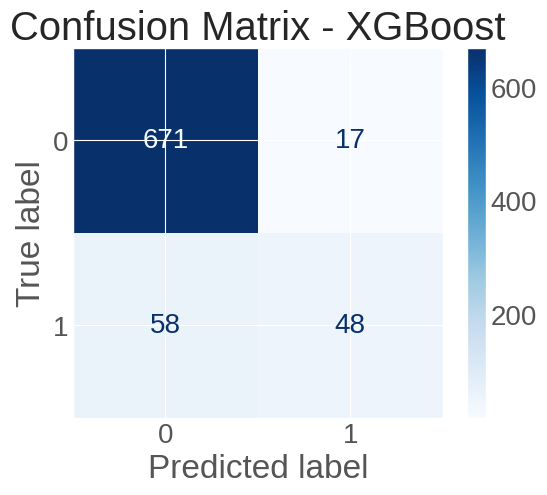

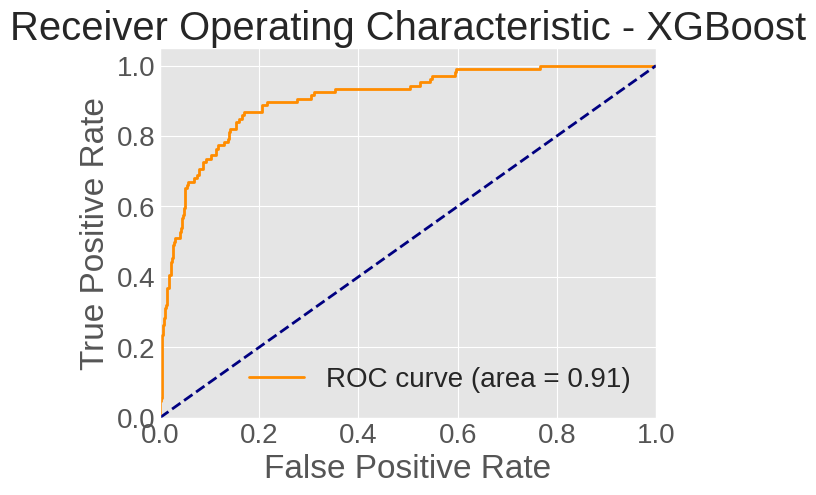

In [157]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import ConfusionMatrixDisplay

# Step 1: Data Preprocessing
# Assuming 'dod' is the target variable for predicting in-hospital mortality
target_column = 'dod'
datetime_columns = ['admittime', 'dischtime']  # Specify the datetime columns here
categorical_columns = ['insurance', 'marital_status', 'race', 'gender']

# Drop datetime columns if they're not relevant for the model
merged_df = merged_df.drop(columns=datetime_columns)

# One-hot encode categorical columns
merged_df = pd.get_dummies(merged_df, columns=categorical_columns, drop_first=True)

# Define features (X) and target (y)
X = merged_df.drop(columns=[target_column])  # Features
y = merged_df[target_column]                 # Target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: XGBoost with Hyperparameter Tuning
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Define hyperparameter grid for tuning
xgb_param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Perform RandomizedSearchCV for XGBoost
xgb_random = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_grid,
    n_iter=50,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the model to the training data
xgb_random.fit(X_train, y_train)

# Step 3: Evaluate XGBoost Model Performance
# Predict on the test set
y_pred_xgb = xgb_random.best_estimator_.predict(X_test)
y_pred_xgb_proba = xgb_random.best_estimator_.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
xgb_roc_auc = roc_auc_score(y_test, y_pred_xgb_proba)
print("XGBoost ROC AUC:", xgb_roc_auc)

# Additional Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred_xgb)
precision = precision_score(y_test, y_pred_xgb)
recall = recall_score(y_test, y_pred_xgb)

print("\nXGBoost Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("ROC AUC Score:", xgb_roc_auc)

# Classification report
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=[0, 1])
disp_xgb.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - XGBoost")
plt.show()

# ROC Curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb_proba)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure()
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - XGBoost')
plt.legend(loc="lower right")
plt.show()


<ipython-input-158-b77ad9b4b482>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


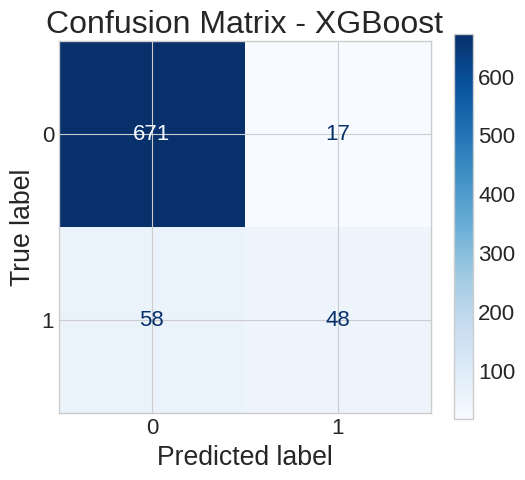

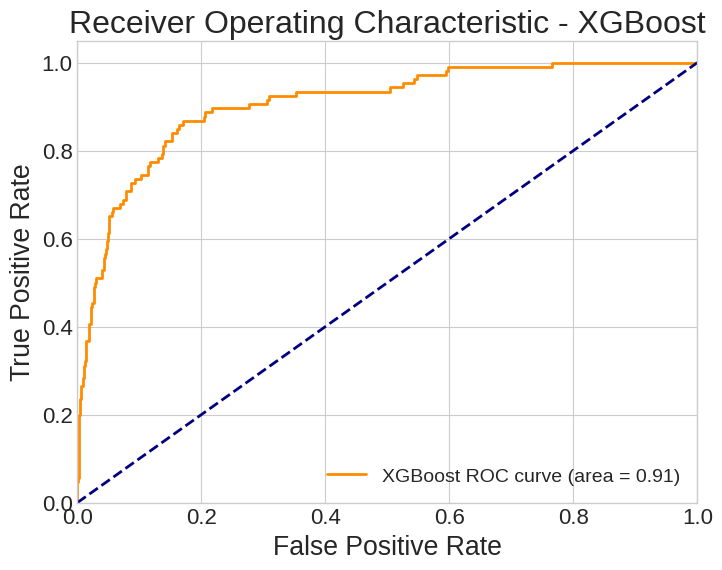

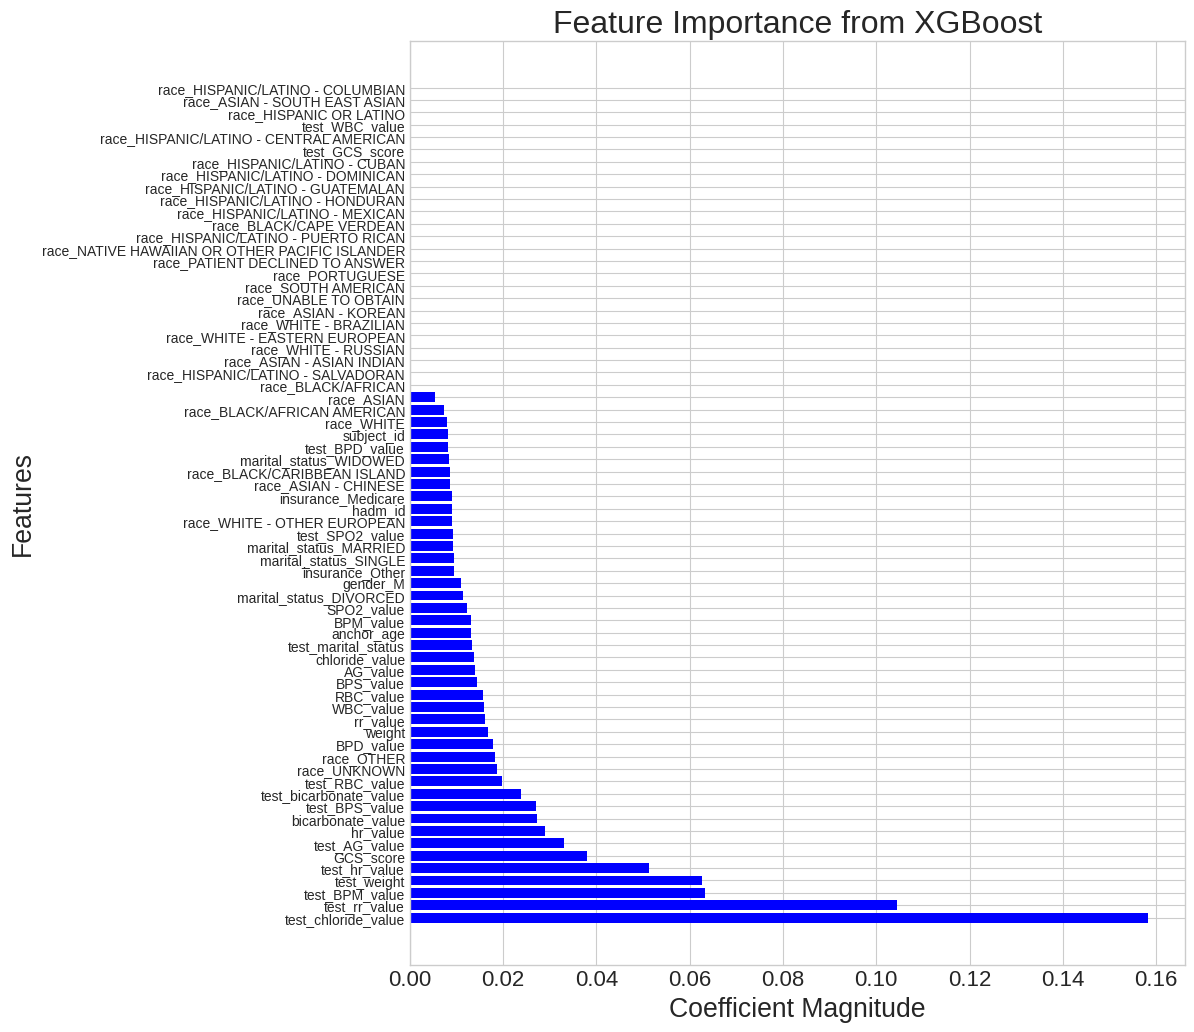

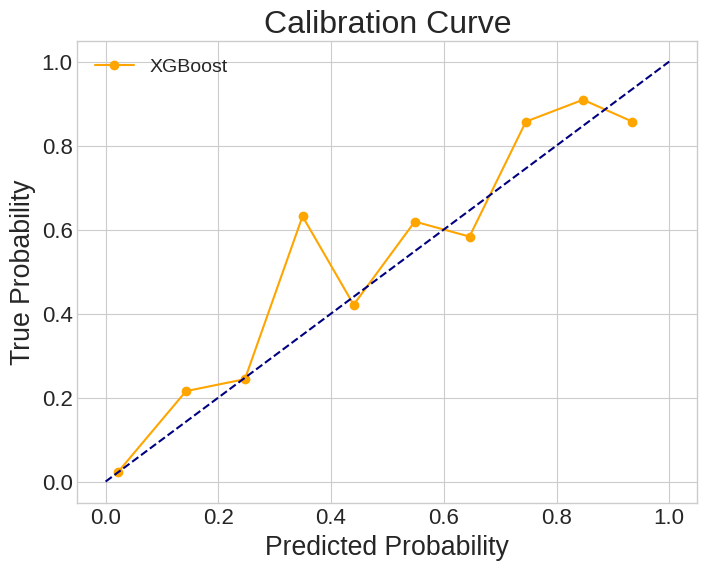

In [158]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.calibration import calibration_curve
import seaborn as sns

# Style settings for cleaner visuals
plt.style.use('seaborn-whitegrid')
font = {'size': 16}
plt.rc('font', **font)

# Step 1: Confusion Matrix for XGBoost
y_pred_xgb_binary = (y_pred_xgb_proba > 0.5).astype(int)
cm_xgb = confusion_matrix(y_test, y_pred_xgb_binary)
fig, ax = plt.subplots(figsize=(6, 5))
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=[0, 1])
disp_xgb.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')
plt.title("Confusion Matrix - XGBoost")
plt.show()

# Step 2: ROC Curve for XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb_proba)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label=f'XGBoost ROC curve (area = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - XGBoost')
plt.legend(loc="lower right", fontsize=14)
plt.show()

# Step 3: Feature Importance for XGBoost
xgb_importances = xgb_random.best_estimator_.feature_importances_
features = X.columns
sorted_idx = np.argsort(xgb_importances)
plt.figure(figsize=(10, 12))
plt.barh(range(len(sorted_idx)), xgb_importances[sorted_idx], color='blue', align='center')
plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx], fontsize=10)
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Features')
plt.title('Feature Importance from XGBoost')
plt.gca().invert_yaxis()
plt.show()

# Step 4: Calibration Curve for XGBoost
prob_true, prob_pred = calibration_curve(y_test, y_pred_xgb_proba, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', color='orange', label='XGBoost')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve')
plt.legend(loc="upper left", fontsize=14)
plt.show()


## calibration curve looks reasonably good!

Interpretation:

1. Alignment with the Diagonal: The closer the calibration curve (orange line) is to the diagonal (dashed line), the better calibrated the model is. This indicates that the predicted probabilities are well-aligned with the observed probabilities. In your curve, the orange line is close to the diagonal for most of the probability range, which suggests good calibration.

2. Small Deviations: There are some deviations, especially in the mid-probability range, where the curve dips a bit below the diagonal. This suggests slight underestimation in those probability ranges, but the deviations aren’t extreme.

3. Overall Slope: The curve generally follows an upward trend with increasing predicted probabilities, which is another sign of a well-calibrated model.

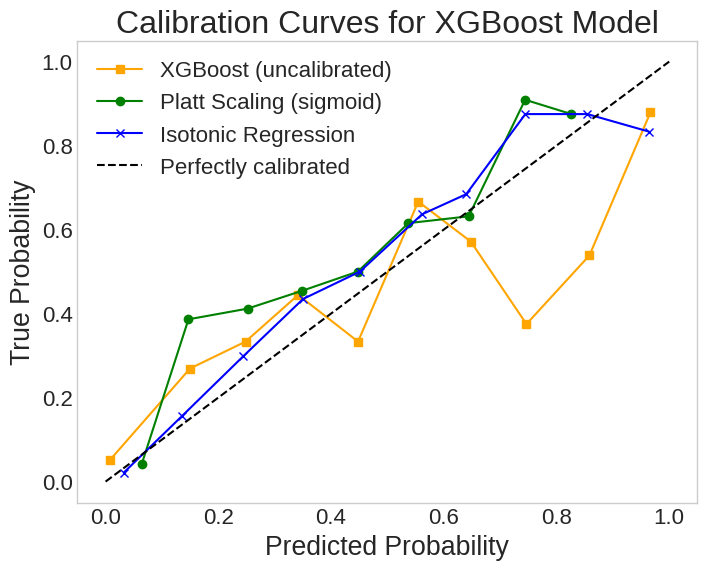

Brier Score (Uncalibrated XGBoost): 0.0784
Brier Score (Platt Scaling): 0.0751
Brier Score (Isotonic Regression): 0.0704


In [159]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss
from xgboost import XGBClassifier

# Step 1: Train the original XGBoost model
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Step 2: Calibrate the model using Platt Scaling and Isotonic Regression
platt_scaler = CalibratedClassifierCV(estimator=xgb_model, method='sigmoid', cv=5)
isotonic_scaler = CalibratedClassifierCV(estimator=xgb_model, method='isotonic', cv=5)

# Fit the calibrated models
platt_scaler.fit(X_train, y_train)
isotonic_scaler.fit(X_train, y_train)

# Step 3: Get predicted probabilities for each method
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
y_pred_proba_platt = platt_scaler.predict_proba(X_test)[:, 1]
y_pred_proba_isotonic = isotonic_scaler.predict_proba(X_test)[:, 1]

# Step 4: Calculate calibration curves
prob_true_xgb, prob_pred_xgb = calibration_curve(y_test, y_pred_proba_xgb, n_bins=10)
prob_true_platt, prob_pred_platt = calibration_curve(y_test, y_pred_proba_platt, n_bins=10)
prob_true_isotonic, prob_pred_isotonic = calibration_curve(y_test, y_pred_proba_isotonic, n_bins=10)

# Step 5: Plot the calibration curves
plt.figure(figsize=(8, 6))
plt.plot(prob_pred_xgb, prob_true_xgb, "s-", label="XGBoost (uncalibrated)", color="orange")
plt.plot(prob_pred_platt, prob_true_platt, "o-", label="Platt Scaling (sigmoid)", color="green")
plt.plot(prob_pred_isotonic, prob_true_isotonic, "x-", label="Isotonic Regression", color="blue")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")

plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curves for XGBoost Model")
plt.legend(loc="best")
plt.grid()
plt.show()

# Step 6: Optional - Brier Scores for Comparison
brier_xgb = brier_score_loss(y_test, y_pred_proba_xgb)
brier_platt = brier_score_loss(y_test, y_pred_proba_platt)
brier_isotonic = brier_score_loss(y_test, y_pred_proba_isotonic)

print(f"Brier Score (Uncalibrated XGBoost): {brier_xgb:.4f}")
print(f"Brier Score (Platt Scaling): {brier_platt:.4f}")
print(f"Brier Score (Isotonic Regression): {brier_isotonic:.4f}")


Interpretation of the plot:

1. XGBoost (Uncalibrated) - The orange line represents the uncalibrated XGBoost model. It has some deviation from the ideal calibration line (dotted black), indicating that the original model's predicted probabilities may not be perfectly aligned with actual outcomes.

2. Platt Scaling (Sigmoid) - The green line represents the model calibrated with Platt scaling. This method generally smooths the probabilities and pulls them closer to the diagonal, making predictions more calibrated across lower and mid-range probabilities.

3. Isotonic Regression - The blue line indicates calibration using isotonic regression. Isotonic regression provides a non-linear mapping of predicted probabilities to actual probabilities and tends to improve calibration, especially for larger datasets. However, it may sometimes introduce variance at specific probability levels, as seen in the curve.

### Overall Assessment
1. Close alignment with the diagonal line indicates good calibration.
2. Platt Scaling seems to improve calibration across a broader range of probabilities, but Isotonic Regression might provide a tighter fit in certain sections.